# **Environment setting**

In [3]:
# python version: 3.7.7
# tensorflow version: 2.3.0
!pip install imagecodecs

     |████████████████████████████████| 17.9MB 1.4MB/s 


# **Import, path and read raw images**

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage as ndi
from skimage.morphology import watershed
from skimage.feature import peak_local_max

import skimage.io as io
import skimage.transform as trans

from math import sqrt
import sys
import os
from random import randint

# if you want to run the demo, Pleast set the current file path and raw data path
current_dir = '/content/drive/Colab/sub/' # current folder path
raw_path = '/content/drive/Colab/data/DIC-C2DH-HeLa/Sequence 1/' # data sequence path
save_path = current_dir + 'res_createdByDemo/'

In [3]:
print(raw_path)
print(save_path)

# make a folder to save output results
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:       
        os.makedirs(path) 
mkdir(current_dir + 'res_createdByDemo/')

# save raw image numpy
raw_data = np.asarray(list(io.ImageCollection(raw_path + '*.tif')))
np.save(save_path + "s_raw.npy", raw_data)
print(raw_data.shape)
print("raw saved!")

/content/drive/Colab/data/DIC-C2DH-HeLa/Sequence 1/
/content/drive/Colab/sub/res_createdByDemo/
(84, 512, 512)
raw saved!


# **Use Unet and masks to train model**


*   We used addtional masks to train the model
*   If you want to do the training process again, 
you can download the masks from here.  
http://celltrackingchallenge.net/2d-datasets/
*   Or you want to directly use the model we have trained
 to save time(may cost more than an hour), and due to the submision size limition, you need to download here which we shared by a private google drive link. Put it in the current file folder, then just skip to the predict part.  
https://drive.google.com/file/d/1KeCRhRZowxfwt4_0NZy82lOVc_IK4NQc/view?usp=sharing






## Get eroded masks

In [13]:
# please open the makeErosion.py and change your mask file path to run the function
# if the system can't find python file, cd to the current folder
%cd /content/drive/Colab/sub/
%run maskErosion.py

/content/drive/Colab/sub
erode mask 1...
(84, 512, 512)
mask 1 done!

erode mask 2...
(84, 512, 512)
mask 2 done!

all done, Thank you!


## Train model

In [14]:
# please open the unet_data.py(not train.py) and change your file path to run the function
# And you can set the numbers of epochs and steps_per_epoch in unet_train.py
# We use the environment of google colab to complete the whole training with GPU.
%run unet_train.py

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 512, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 512, 32)      320       
_________________________________________________________________
dropout (Dropout)            (None, 512, 512, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 256, 256, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 256, 64)     

200/200 [==============================] - 122s 608ms/step - loss: 0.4947 - binary_accuracy: 0.7176 - val_loss: 0.2783 - val_binary_accuracy: 0.8726
Epoch 2/20
200/200 [==============================] - 120s 599ms/step - loss: 0.2301 - binary_accuracy: 0.8907 - val_loss: 0.1485 - val_binary_accuracy: 0.9404
Epoch 3/20
200/200 [==============================] - 122s 611ms/step - loss: 0.1833 - binary_accuracy: 0.9133 - val_loss: 0.1323 - val_binary_accuracy: 0.9451
Epoch 4/20
200/200 [==============================] - 123s 617ms/step - loss: 0.1697 - binary_accuracy: 0.9196 - val_loss: 0.1226 - val_binary_accuracy: 0.9506
Epoch 5/20
200/200 [==============================] - 123s 617ms/step - loss: 0.1634 - binary_accuracy: 0.9228 - val_loss: 0.1361 - val_binary_accuracy: 0.9443
Epoch 6/20
200/200 [==============================] - 123s 616ms/step - loss: 0.1529 - binary_accuracy: 0.9271 - val_loss: 0.1217 - val_binary_accuracy: 0.9508
Epoch 7/20
200/200 [==============================]

## Predict

84


<function matplotlib.pyplot.show>

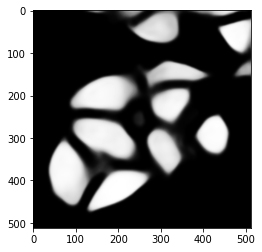

In [19]:
# please open the unet_data.py(not train.py) and change your file path to run the function
from tensorflow import keras
from unet_data import get_train_val

test_images = get_train_val(data='test')
model_fname = 'DIC_model.h5'
# if you failed to load the mode, it might be something about tensorflow version
# tensorflow 2.3.0 has been tested successfully
model = keras.models.load_model(model_fname)
probs = np.squeeze(model.predict(test_images[:84]))
# test_images[0:84] is sequence 1, test_images[84:168] is sequence 2
# test_images[168:283] is sequence 3, test_images[283:398] is sequence 4

#print(np.amin(probs)) # lowest prob
#print(np.amax(probs)) # highest prob

print(len(probs))
plt.imshow(probs[0], 'gray')
plt.show

In [20]:
# save result numpy
pre_data = probs
np.save(save_path + "s_pre.npy", probs)
print("prediection saved!")

prediection saved!


## Results of deep learning part

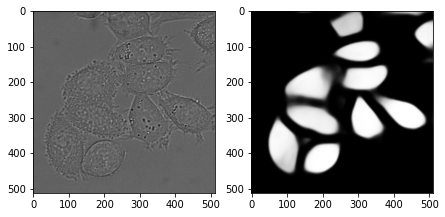

In [25]:
raw_data = np.load(save_path + "s_raw.npy")
pre_data = np.load(save_path + "s_pre.npy")

plt.figure(figsize=(15,8))
plt.subplot(141)
plt.imshow(raw_data[8],'gray')
plt.subplot(142)
plt.imshow(pre_data[8],'gray')
plt.show()

# Draw contours

In [26]:
raw_data = np.load(save_path + "s_raw.npy")
pre_data = np.load(save_path + "s_pre.npy")

In [27]:
from drawContour import not_close_to_boundary
from drawContour import draw_contours

length = raw_data.shape[0]
res = [None]*length
for i in range(length):
    img = raw_data[i]
    pre = pre_data[i]
    
    draw, bound, center, fitrect= draw_contours(img,pre,i)
    res[i] = {}
    res[i]['draw_img'] = draw
    res[i]['cell_num'] = len(center)
    res[i]['fitRect'] = fitrect
    res[i]['boxs'] = bound

contour_res = res
np.save(save_path + 's_contour_res.npy', contour_res) 
print("contour_res saved!")

contour_res saved!


## Results of draw_contour part

frame: 8


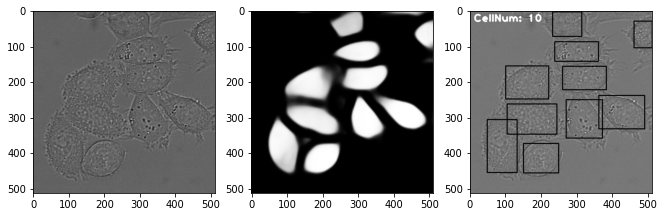

In [28]:
print("frame: 8")
plt.figure(figsize=(15,8))
plt.subplot(141)
plt.imshow(raw_data[8],'gray')
plt.subplot(142)
plt.imshow(pre_data[8],'gray')
plt.subplot(143)
plt.imshow(contour_res[8]['draw_img'],'gray')
plt.show()

# **Detect division**

In [29]:
raw_data = np.load(save_path + "s_raw.npy")
pre_data = np.load(save_path + "s_pre.npy")
res_data = np.load(save_path + 's_contour_res.npy',allow_pickle=True)

In [30]:
from findDivision import find_division
from findDivision import find_status

output_data = res_data.copy()
for i in range(res_data.shape[0]):
    img = raw_data[i]
    out,black_circles = find_division(raw_data[i])

    fit_list = res_data[i]['fitRect']
    centers = []
    division = []
    for k, rect in enumerate(fit_list):
        if find_status(black_circles, rect[2]): # when the center is in black circle
            division.append(rect)
        output_data[i]['fitRect'][k].append(black_circles)

    draw = res_data[i]['draw_img'].copy()
    if division:
        for div in division:
            b = cv2.boxPoints((div[2],div[3],0))
            b = np.int0(b)
            cv2.drawContours(draw,[b],0,(0,0,255),12)

    output_data[i]['draw_img'] = draw

res_new_data = output_data
np.save(save_path + 's_new_res.npy', output_data)
print("updated_res saved!")

updated_res saved!


## Results of detect_division part

frame: 21


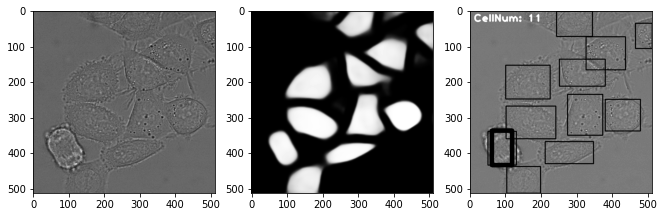

frame: 22


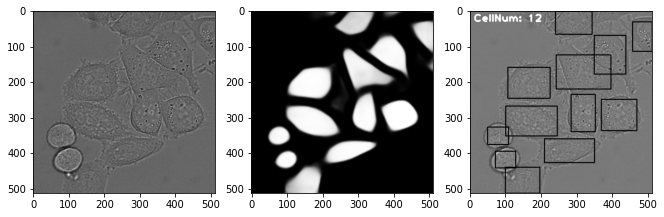

In [31]:
for i in range(21,23):
    print("frame:",i)
    plt.figure(figsize=(15,8))
    plt.subplot(141)
    plt.imshow(raw_data[i],'gray')
    plt.subplot(142)
    plt.imshow(pre_data[i],'gray')
    plt.subplot(143)
    plt.imshow(res_new_data[i]['draw_img'],'gray')
    plt.show()

# **Tracking**

In [32]:
raw_data = np.load(save_path + "s_raw.npy")
pre_data = np.load(save_path + "s_pre.npy")
res_data = np.load(save_path + 's_contour_res.npy',allow_pickle=True)
res_new_data = np.load(save_path + 's_new_res.npy',allow_pickle=True)

In [33]:
from trackingDIC import cell_track
path_data = cell_track(res_new_data)

In [34]:
np.save(save_path + 's_path.npy',path_data)
print("path_data saved!")

path_data saved!


# **Draw trajectories**

In [35]:
raw_data = np.load(save_path + "s_raw.npy")
pre_data = np.load(save_path + "s_pre.npy")
res_data = np.load(save_path + 's_contour_res.npy',allow_pickle=True)
res_new_data = np.load(save_path + 's_new_res.npy',allow_pickle=True)
path_data = np.load(save_path + 's_path.npy',allow_pickle=True)

In [36]:
draw_data = []
for res in res_new_data:
    draw_data.append(res['draw_img'])

In [37]:
from drawCalculate import draw_and_calculate
draws, outputs = draw_and_calculate(path_data, draw_data)

In [38]:
np.save(save_path+'s_final_output.npy',outputs)
np.save(save_path+'s_final_draw.npy',draws)
print("results saved!")

results saved!


# **Results of final part**
we have complete the main part of our code and get two final results, which are:
1. The printing outputs present cell Id, current frame number, cell speed, total distance, net distance and ratio.  
example output: 1: [(90, 385), 6.325, 84.176, 9.22, 9.13]
2. The image outputs present 4 periods of inputs which are:  
raw imgae, predicted image, imgae with box contours, image including cellId and trajectories.

frame: 21
{1: [(90, 385), 6.325, 84.176, 9.22, 9.13], 2: [(325, 291), 1.414, 335.425, 40.719, 8.238], 3: [(171, 312), 7.211, 124.487, 15.524, 8.019], 4: [(432, 290), 12.042, 225.797, 5.831, 38.724], 5: [(308, 180), 41.593, 344.647, 36.401, 9.468], 6: [(162, 200), 11.18, 135.671, 6.325, 21.452], 7: [(383, 115), 24.698, 443.251, 56.436, 7.854], 8: [(488, 70), 8.0, 111.849, 7.81, 14.321], 9: [(294, 35), 2.236, 158.847, 11.045, 14.381], 10: [(150, 474), 3.606, 77.588, 51.0, 1.521], 11: [(279, 395), 5.099, 94.334, 44.283, 2.13]}


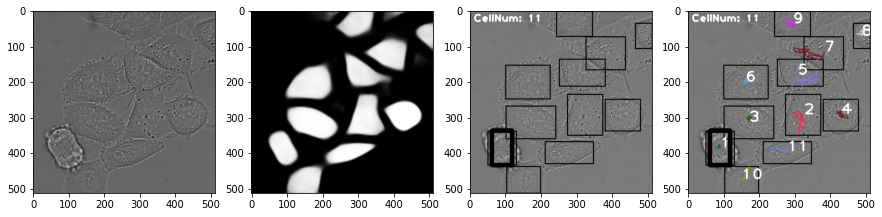

frame: 22
{2: [(317, 287), 8.944, 344.37, 41.976, 8.204], 3: [(172, 309), 3.162, 127.649, 13.0, 9.819], 4: [(420, 290), 12.0, 237.797, 7.616, 31.224], 5: [(311, 179), 3.162, 347.809, 36.401, 9.555], 6: [(165, 202), 3.606, 139.277, 8.062, 17.275], 7: [(402, 121), 19.925, 463.176, 71.47, 6.481], 8: [(484, 71), 4.123, 115.972, 7.071, 16.401], 9: [(291, 32), 4.243, 163.089, 14.56, 11.201], 10: [(147, 476), 3.606, 81.194, 54.203, 1.498], 11: [(278, 389), 6.083, 100.417, 44.385, 2.262], 12: [(99, 418), 0, 0, 0.0, 0], 13: [(78, 350), 0, 0, 0.0, 0]}


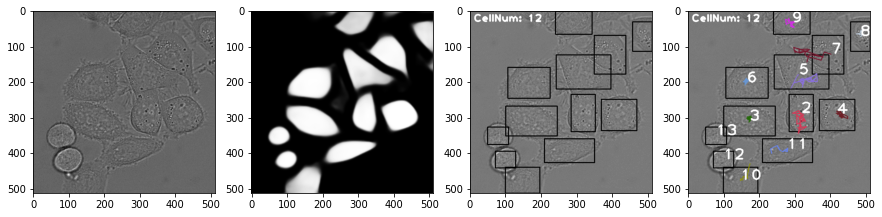

In [39]:
for i in range(21,23):
    print("frame:",i)
    print(outputs[i])
    plt.figure(figsize=(15,8))
    plt.subplot(141)
    plt.imshow(raw_data[i],'gray')
    plt.subplot(142)
    plt.imshow(pre_data[i],'gray')
    plt.subplot(143)
    plt.imshow(res_new_data[i]['draw_img'],'gray')
    plt.subplot(144)
    plt.imshow(draws[i])
    plt.show()

# **Visual live output**
we also develop two functions to present our results lively


1.   output cell information in real-time, especially for task3.  
But the function cannot run in this notebook, you need to run the python file called "task3_visualize" outside. Here is quick guidance.  


*   change the path in python file to read 's_final_draw.npy' and s_final_output.npy'
*   press any key but 'q' to go to next frame
*   click on the cell you want to select, and the relative information will print in the command line window.
*   information output including the current frame number, cell Id, speed, total distance, net distance it travelled and the confinement ratio of cell motion.
*   press 'q' to shut down the function.

2.   save all the images as one video, you can just run the code below. The video is saved in the folder called "res_createdByDemo".



In [4]:
final_output = np.load(save_path + 's_final_output.npy',allow_pickle=True)
final_draw = np.load(save_path + 's_final_draw.npy',allow_pickle=True)

In [6]:
image_data = final_draw

video_path = save_path + 'video.avi'
video_fps = 5
video_size = (512,512)
video_type = cv2.VideoWriter_fourcc(*'XVID')

writer = cv2.VideoWriter(video_path, video_type, video_fps, video_size, isColor = True)
for i in range(image_data.shape[0]) :
    writer.write(image_data[i])

writer.release()
print('video saved!')

video saved!
